# HMM Feature Pruning Experiment
Drop one feature at a time to identify the best feature set for HMM classification.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Load features
df_feat = pd.read_pickle('df_feat.pkl')
target_col = 'mood_cat'
exclude_cols = ['nextday', 'mood_cat']
feature_cols = [c for c in df_feat.columns if c not in exclude_cols]
X = df_feat[feature_cols]
y = df_feat[target_col]
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [4]:
# Scale features for HMM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
# Baseline HMM accuracy
models = {}
for label in np.unique(y_train):
    m = GaussianHMM(n_components=1, covariance_type='full', n_iter=100, random_state=42)
    m.fit(X_train_scaled[y_train == label])
    models[label] = m

def predict_hmm(models, X):
    preds = []
    for obs in X:
        scores = {lbl: mdl.score(obs.reshape(1, -1)) for lbl, mdl in models.items()}
        preds.append(max(scores, key=scores.get))
    return np.array(preds)

y_pred_hmm = predict_hmm(models, X_test_scaled)
baseline_hmm_acc = accuracy_score(y_test, y_pred_hmm)
print(f"Baseline HMM accuracy: {baseline_hmm_acc:.3f}")


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

Baseline HMM accuracy: 0.400


In [6]:
# Evaluation function for HMM on feature subsets
def eval_hmm(feats):
    scaler_sub = StandardScaler()
    X_tr = scaler_sub.fit_transform(X_train[feats])
    X_te = scaler_sub.transform(X_test[feats])
    mods = {}
    for lbl in np.unique(y_train):
        hm = GaussianHMM(n_components=1, covariance_type='full', n_iter=100, random_state=42)
        hm.fit(X_tr[y_train == lbl])
        mods[lbl] = hm
    y_pr = predict_hmm(mods, X_te)
    return accuracy_score(y_test, y_pr)


In [7]:
# Drop‑one evaluation for HMM
results = []
for f in feature_cols:
    feats = [c for c in feature_cols if c != f]
    acc = eval_hmm(feats)
    results.append({'feature': f, 'hmm_acc': acc})

results_df = pd.DataFrame(results)
results_df['delta'] = baseline_hmm_acc - results_df['hmm_acc']
# sort by minimal accuracy drop
results_df = results_df.sort_values('delta')
print(results_df.head(10))


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

           feature   hmm_acc     delta
5      appCat.game  0.434483 -0.034483
6    appCat.office  0.420690 -0.020690
7     appCat.other  0.420690 -0.020690
21  call_sms_ratio  0.413793 -0.013793
1   appCat.builtin  0.413793 -0.013793
19      screen_log  0.413793 -0.013793
18             sms  0.413793 -0.013793
4   appCat.finance  0.413793 -0.013793
17          screen  0.413793 -0.013793
13            call  0.413793 -0.013793


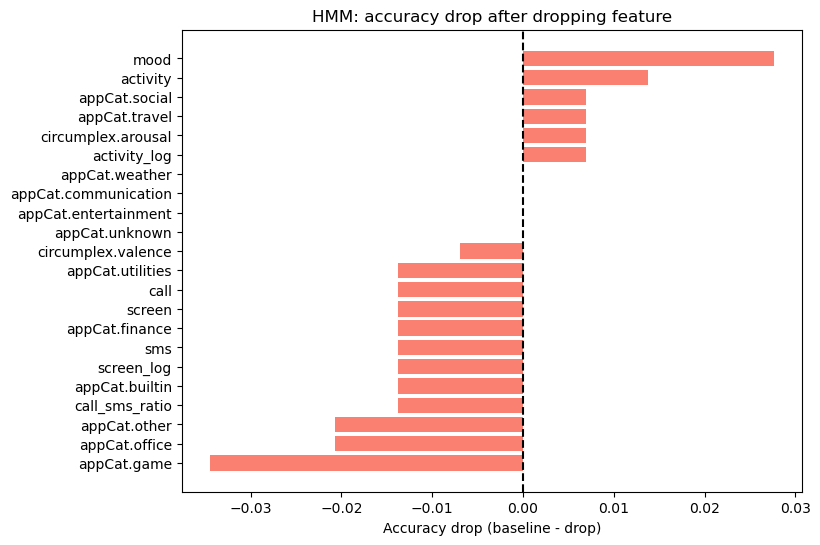

In [8]:
# Plot HMM drop‑impact
plt.figure(figsize=(8,6))
plt.barh(results_df['feature'], results_df['delta'], color='salmon')
plt.axvline(0, color='k', linestyle='--')
plt.title('HMM: accuracy drop after dropping feature')
plt.xlabel('Accuracy drop (baseline - drop)')
plt.show()


In [10]:
# Identify the single feature whose removal hurts HMM least
best_drop = results_df.loc[results_df['delta'].idxmin(), 'feature']

# Build the best feature list
best_hmm_features = [f for f in feature_cols if f != best_drop]

print(f"Dropping ‘{best_drop}’ gives the highest HMM accuracy.")
print("Best HMM feature set:")
print(best_hmm_features)
print(len(best_hmm_features))

Dropping ‘appCat.game’ gives the highest HMM accuracy.
Best HMM feature set:
['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'circumplex.arousal', 'circumplex.valence', 'mood', 'screen', 'sms', 'screen_log', 'activity_log', 'call_sms_ratio']
21


In [11]:
# Greedy backward elimination for HMM
remaining = feature_cols.copy()
best_acc = baseline_hmm_acc

while True:
    # try dropping each remaining feature
    accs = {}
    for f in remaining:
        feats = [c for c in remaining if c!=f]
        accs[f] = eval_hmm(feats)
    # pick the drop that yields highest accuracy
    drop, acc_after = max(accs.items(), key=lambda kv: kv[1])
    if acc_after >= best_acc:
        print(f"Dropping {drop}: HMM accuracy {acc_after:.3f} (prev {best_acc:.3f})")
        remaining.remove(drop)
        best_acc = acc_after
    else:
        break

print("\nFinal HMM feature set:")
print(remaining)
print(f"Accuracy = {best_acc:.3f}")

c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

Dropping appCat.game: HMM accuracy 0.434 (prev 0.400)


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

Dropping screen: HMM accuracy 0.462 (prev 0.434)


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

Dropping appCat.other: HMM accuracy 0.476 (prev 0.462)


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

Dropping appCat.utilities: HMM accuracy 0.490 (prev 0.476)


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14


Final HMM feature set:
['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.office', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.weather', 'call', 'circumplex.arousal', 'circumplex.valence', 'mood', 'sms', 'screen_log', 'activity_log', 'call_sms_ratio']
Accuracy = 0.490


In [ ]:
best_hmm_features = remaining

print(f"Dropping ‘{best_hmm_features}’ gives the highest HMM accuracy.")
print("Best HMM feature set:")
print(best_hmm_features)
print(len(best_hmm_features))

Dropping ‘appCat.game’ gives the highest HMM accuracy.
Best HMM feature set:
['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.office', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.weather', 'call', 'circumplex.arousal', 'circumplex.valence', 'mood', 'sms', 'screen_log', 'activity_log', 'call_sms_ratio']
18


In [16]:
print(feature_cols)
print(len(feature_cols))

['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'circumplex.arousal', 'circumplex.valence', 'mood', 'screen', 'sms', 'screen_log', 'activity_log', 'call_sms_ratio']
22


In [ ]:
# Plot HMM drop‑impact
plt.figure(figsize=(8,6))
plt.barh(results_df['feature'], results_df['delta'], color='salmon')
plt.axvline(0, color='k', linestyle='--')
plt.title('HMM: accuracy drop after dropping feature')
plt.xlabel('Accuracy drop (baseline - drop)')
plt.show()
